# Training Notebook

**Date:** January 27th of 2025
**Description:** ...

**Content**

### Important Assumptions
The following are assumptions I have taken to limit the scope of the project and clarify
when it is needed.

- a. **How to use session_id feature?** A session id is a unique identifier to a
particular sesson during which an order is placed. A session typically refers to a 
continuous interaction between a user and the webshop. Each order, when analized, will 
have the data from all the transactions happening before in the same session.

**Assumption**: It is not possible to know if a transaction is really a fraud or not
after a long time. In other words, I do not have the target variable of previous requests
from the same session_Id.

**Hypothesis**

**Multiple orders from the same session:** If a single session has multiple orders with 
high prices, inconsistent devices, or other suspicious patterns, it may indicate fraud.

**Unusual session activity:** If a session has orders with abnormal characteristics
 (e.g., several orders in quick succession or from a device that's typically not used 
 for purchases), this can help detect fraud.



## 0. Set Up

In [4]:
import os
import pandas as pd
import numpy as np
import fastparquet
import sklearn as scikit_learn
import matplotlib as plt
import seaborn as sns
from boruta import BorutaPy
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
import pickle

In [5]:
from utils.data_profiling import analyze_dataframe
from utils.data_enrich import FraudDetectionDataset
from utils.feature_discrimination import FeatureEvaluator
from utils.feature_selection import FeatureSelector
from utils.train_test_splitter import TimeSeriesSplitter
from utils.model_trainer import FraudModelTrainer

## 1. Data Discovery
**Objective:** This chapter describes the type of the variable and includes an
univariate analysis of the data set.

In [6]:
# Get the current directory
current_directory = os.getcwd()

# Define the path to the file
file_path = os.path.join(current_directory, "data", "data.parquet")

# Read the Parquet file
try:
    df = pd.read_parquet(file_path)
    print(f"File loaded successfully. Here's a preview:\n{df.head()}")
except FileNotFoundError:
    print(f"File not found at: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Ensure 'timestamp' column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

File loaded successfully. Here's a preview:
                   timestamp session_id device   price  is_fraud
0 2023-02-01 00:00:27.112402   6548112c    ios  212.99     False
1 2023-02-01 00:01:17.058324   6548112c    ios   37.99     False
2 2023-02-01 00:01:38.652451   6548112c    ios   68.99     False
3 2023-02-01 00:01:47.895385   6548112c    ios   61.99     False
4 2023-02-01 00:02:48.358924   6548112c    ios  633.99     False


In [7]:
# Example DataFrame (assuming 'df' is your DataFrame)
result = analyze_dataframe(df)

# Print the analysis result
for column, stats in result.items():
    print(f"Analysis for {column}:")
    for key, value in stats.items():
        print(f"  {key}: {value}")
    print("\n")

Analysis for timestamp:
  Min: 2023-02-01 00:00:02.923795
  Max: 2023-02-14 23:59:57.987484


Analysis for session_id:
  Type: object
  Unique Categories: 24428
  Missing: 0


Analysis for device:
  Type: object
  Unique Categories: 2
  Category Frequencies: {'android': {'Count': 293435, 'Percentage': '56.52%'}, 'ios': {'Count': 225713, 'Percentage': '43.48%'}}
  Missing: 0


Analysis for price:
  Type: float64
  Min: 2.99
  Max: 1631.99
  Mean: 165.52734187553452
  Median: 99.95
  Q1: 49.99
  Q3: 204.95000000000002
  Missing: 0


Analysis for is_fraud:
  Unique Categories: 2
  Category Frequencies: {False: {'Count': 515985, 'Percentage': '99.39%'}, True: {'Count': 3163, 'Percentage': '0.61%'}}
  Missing: 0




### Conclusions Data Discovery

1. **Timestamp: (Time Feature)** There is data for the first 14 days of February 
(Two weeks), this information is includes hour, minutes, seconds and milliseconds. 
It is possible to analize seasonality by day of the week, hours, etc. 

2. **Session_id: (String - Key feature)** There is a great number of requests coming 
from the session_id. 
It is key to analize the behavior of the current request and the previous requests from
the same session_id to obtain a fruitful feature engineering. It is possible to create 
a great variety of features such as: time when the first request was made, maximum price
of an item within the same session_id, number of different device within the same session.

3. **Device: (Binomial Category)** Android represents 57% of the requests 43% are coming 
from IOS, it might be interesting to understand which device has a higher probability of
being a fraudster.

4. **is_fraud (Boolean Target Variable):** As it is expected in credit risk analysis, 
there  is a a high imbalance when comparing good cases against bad cases. It is important 
to take it into account when optimizing the model (*accuray* of the model is not the
right KPI to optimize.)

## 2. Data Enrichment

**Objective:** Create additional features using raw features using my business knowledge.

**Disclaimer:** In my personal/professional experience this is by far the most 
important part of this entire project. Business knowledge and creativity in order to 
create relevant and performant features is what makes this model successful in  real life. 
However, I do not want to spend a lot of time on this and I spend just a bit of time
creating the features that comes first in my mind.

In [8]:
# Instantiate and enrich the dataset
enrich_dataset = FraudDetectionDataset(df)
enrich_dataset.enrich_features()

# Get the enriched dataset
enriched_df = enrich_dataset.get_dataset()

In [9]:
# Nice to have some manual validation
enriched_df.iloc[409:420]

,price,is_fraud,day_of_week,is_weekend,hour_of_day,period_Night,period_Morning,period_Afternoon,time_since_first,total_transactions_so_far,avg_price_so_far,total_price_so_far,rolling_sum_3,rolling_mean_3,rolling_std_3,device_android,price_log,price_sqrt,price_reciprocal
409,21.95,False,2,0,0,True,False,False,0.000000,1,0.000000,0.00,-1.00,-1.000000,-1.000000,False,3.133318,4.685083,0.045558
410,143.95,False,2,0,0,True,False,False,22.445022,2,21.950000,21.95,-1.00,-1.000000,-1.000000,False,4.976389,11.997916,0.006947
411,228.95,False,2,0,0,True,False,False,29.355435,3,82.950000,165.90,-1.00,-1.000000,-1.000000,False,5.437862,15.131094,0.004368
412,11.95,False,2,0,0,True,False,False,71.851543,4,131.616667,394.85,394.85,131.616667,104.049668,False,2.561096,3.456877,0.083682
413,140.95,False,2,0,0,True,False,False,72.680524,5,101.700000,406.80,384.85,128.283333,109.345020,False,4.955475,11.872237,0.007095
414,209.95,False,2,0,0,True,False,False,138.353177,6,109.550000,547.75,381.85,127.283333,109.143636,False,5.351621,14.489651,0.004763
415,465.99,False,2,0,0,True,False,False,230.345831,7,126.283333,757.70,362.85,120.950000,100.503731,False,6.146308,21.586802,0.002146
416,280.99,False,2,0,0,True,False,False,249.800974,8,174.812857,1223.69,816.89,272.296667,171.254432,False,5.641872,16.762756,0.003559
417,31.99,False,2,0,0,True,False,False,296.554877,9,188.085000,1504.68,956.93,318.976667,132.179274,False,3.496204,5.655970,0.031260
418,194.95,False,2,0,0,True,False,False,372.190090,10,170.741111,1536.67,778.97,259.656667,217.785062,False,5.277860,13.962450,0.005130


### Summary
- Time features were created to identify seasonlity effects. These features are day of
the week, a boolean to check if it is weekend, hour of the day and moment of the day.

- Summary statistics from previous transaction of the same session such as time from the
first transaction, number of transactios so far, average price, total acumulative price,
and mean sum and standard deviation for the last 3 transactions previous to the current
one.

- A boolean variable to describe the type of device.

- Multiple transformatons of the price such as logarithmic, square root and reciprocal.

## 3. EDA (Explorative & Descriptive Analysis)
**Objective:** Based on the enriched data set, evaluate the discriminatory power of 
each feature by using inferential analysis and data visualization.

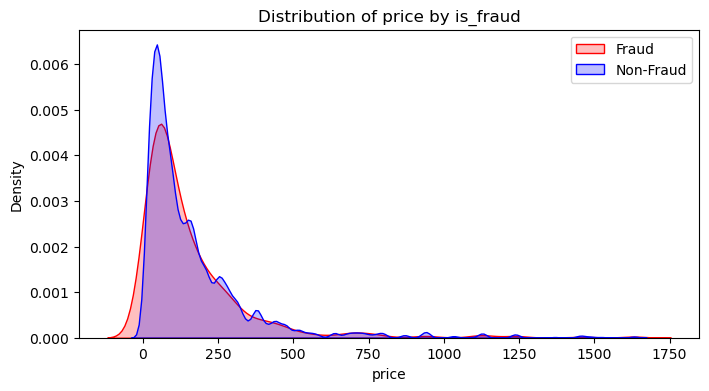

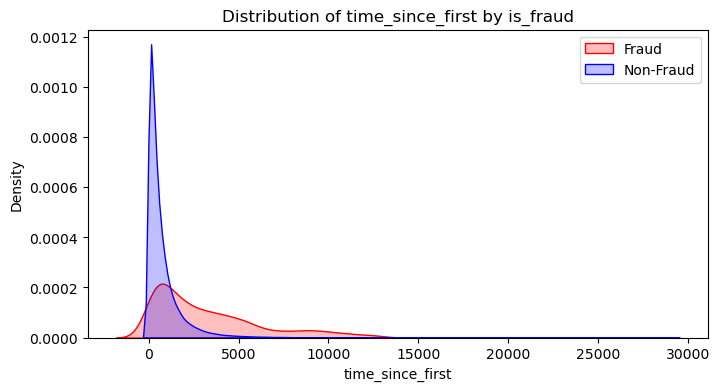

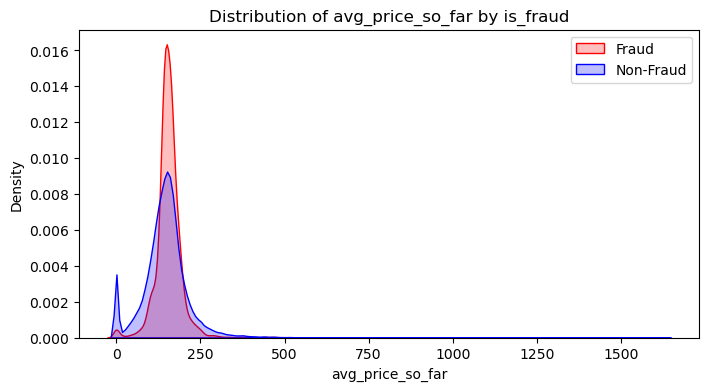

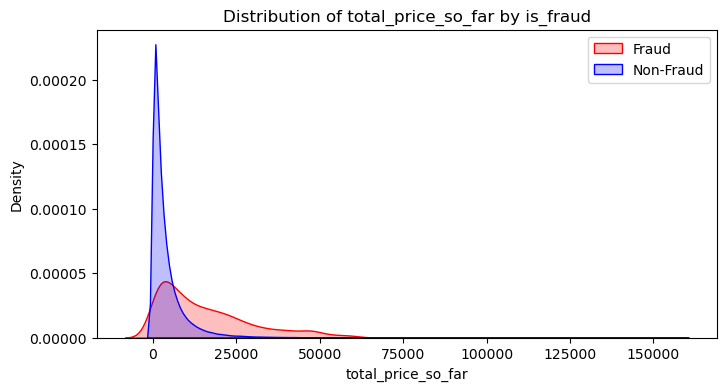

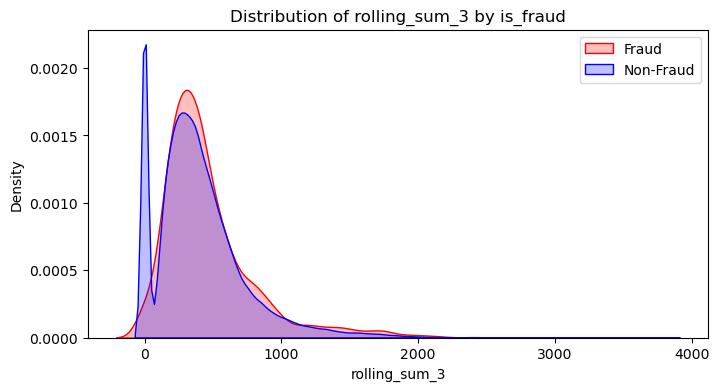

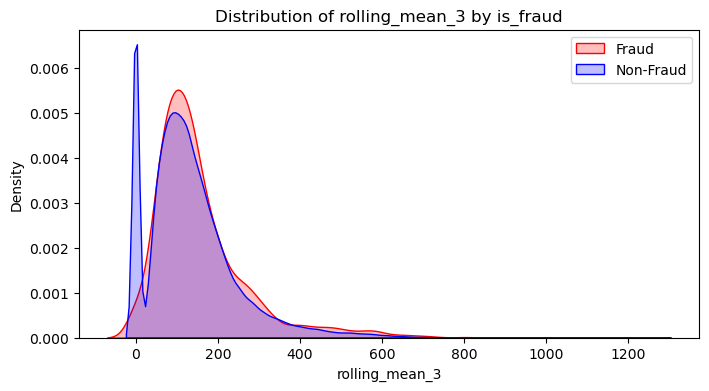

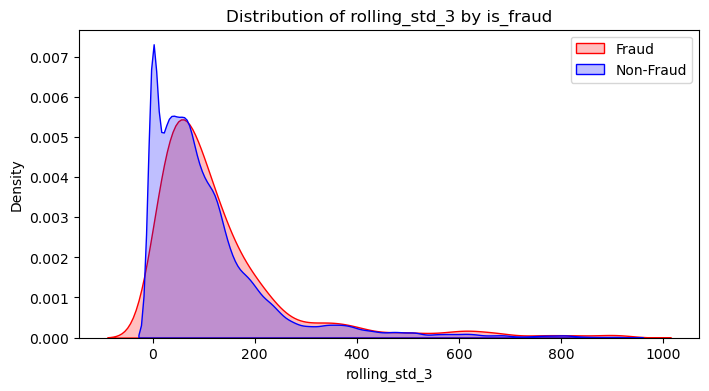

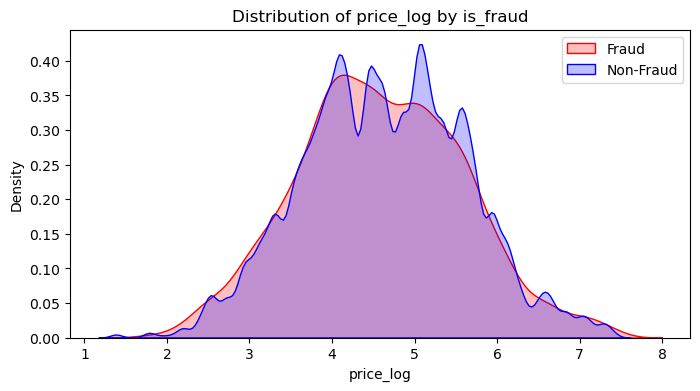

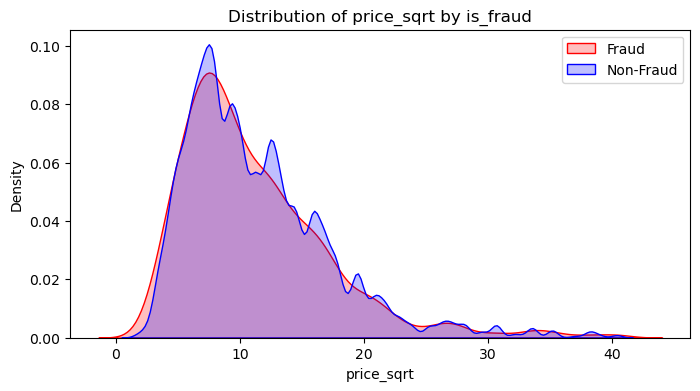

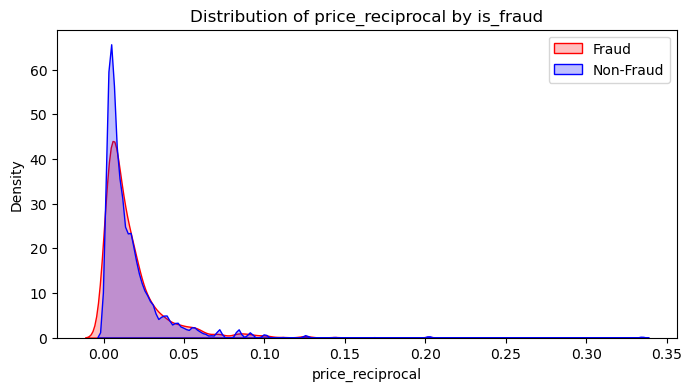

Feature: price
p-value: 0.3215696650564885, Discriminatory Power: No
--------------------------------------------------
Feature: day_of_week
p-value: 1.0664261892328474e-12, Discriminatory Power: Yes
--------------------------------------------------
Feature: is_weekend
p-value: 1.429060818916433e-13, Discriminatory Power: Yes
--------------------------------------------------
Feature: hour_of_day
p-value: 0.8107938635853509, Discriminatory Power: No
--------------------------------------------------
Feature: period_Night
p-value: 0.19796308360556944, Discriminatory Power: No
--------------------------------------------------
Feature: period_Morning
p-value: 2.1265136159786254e-11, Discriminatory Power: Yes
--------------------------------------------------
Feature: period_Afternoon
p-value: 2.4362647180519707e-17, Discriminatory Power: Yes
--------------------------------------------------
Feature: time_since_first
p-value: 0.0, Discriminatory Power: Yes
------------------------------

In [10]:
# Usage
evaluator = FeatureEvaluator(df=enriched_df, target="is_fraud")
results = evaluator.evaluate_all()

# Display results
for feature, metrics in results.items():
    print(f"Feature: {feature}")
    print(f"p-value: {metrics['p_value']}, Discriminatory Power: {metrics['discriminatory_power']}")
    print("-" * 50)

### Conclusions

- Price feature does not provide discriminatory power to differentiate fraud. However,
the non-linear transformations do have discriminatory power. This puts into evidence that
low or high prices might be associated with fraud, while mid-range values are not.

- The hour of the day is too specific to provide discriminatory power, as shown by the 
Kolmogorov-Smirnov test, which indicates no meaningful seasonality throughout the day. 
However, broader periods of the day, such as Morning and Afternoon, encapsulate the data
more effectively, revealing patterns that can be used to discriminate in the ML model.

## 4. Feature Selection
**Objective:** Use feature selection methods to select the best features before introduce
them into the ML model.

1. **Enhanced Model Performance:** Selecting relevant features leads to more accurate and 
efficient models.

2. **Reduced Overfitting:** Including irrelevant features can lead to overfitting, where
the model performs well on the training data but poorly on test data. Feature selection
helps mitigate this issue.

3. **Improved Interpretability:** Models with fewer features are easier to interpret and
explain to stakeholders.

4. **Faster Training and Inference:** Working with a reduced set of features speeds up
both the training and inference phases of the machine learning pipeline.

In [11]:
# Example Usage
selector = FeatureSelector(df=enriched_df, target="is_fraud")
selected_features = selector.select_features()

# Display results
print(selected_features['Voting'])  # Outputs features selected by any method

Permutation Selection Finished
Select K Bests Finished
['avg_price_so_far', 'rolling_sum_3', 'hour_of_day', 'rolling_mean_3', 'rolling_std_3', 'device_android', 'total_transactions_so_far', 'time_since_first', 'total_price_so_far', 'period_Afternoon', 'day_of_week', 'is_weekend']


In [12]:
# Add 'is_fraud' to the list of selected columns
columns_to_select = selected_features['Voting'] + ['price'] +['is_fraud']

# Select the desired columns from the dataset
selected_features_df = enriched_df[columns_to_select]

## 5. Separate Train and Test data set

**Objective:** Split the enriched dataset into training and test datasets.
It is important to emphasize that we are building an algorithm using today's data to
make predictions on tomorrow's data. Therefore, when splitting the data into 80%
training and 20% testing, the training set should consist of the first 80% of the
requests ordered by timestamp.

In [13]:
# Use the Class TimeSeriesSplitter to create a train and test data sets
splitter = TimeSeriesSplitter(selected_features_df, train_size=0.8)
train_data, test_data = splitter.get_train_test_sets()

# Display the sizes of the splits
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 415318
Test set size: 103830


## 6. Machine Learning Optimization

**Objective:** Identify the best Machine Learning Algorithm to generated the best profit
uplift for the portfolio.

The methodology uses multiple machine learning models (Logistic Regression, Random
Forest, and XGBoost) and optimizing them for profitability. By applying SMOTE, the model
addresses class imbalance, ensuring that the training data is representative of both 
fraudulent and non-fraudulent cases. The evaluation of models estimates AUCPR to select
the most  effective model in distinguishing fraud cases while maximizing the potential
for profit uplift.

A standout feature of this approach is its focus on identifying the optimal threshold
for classification. Specifically, profit uplift is calculated for each threshold using
the training dataset, and the threshold that maximizes profit uplift is then applied
to the test dataset.

In [14]:
# Initialize the trainer
trainer = FraudModelTrainer(train_data, target_column='is_fraud', test_data=test_data, 
                            order_price_column='price')

# Train models
trainer.train_models()

# Evaluate on test data
trainer.evaluate_on_test_data()

Training Logistic Regression...
Logistic Regression - AUCPR: 0.0220, Best Threshold: 0.60, Profit Uplift: $78702.76
Training Random Forest...
Random Forest - AUCPR: 0.5075, Best Threshold: 0.10, Profit Uplift: $110936.41
Training XGBoost...
XGBoost - AUCPR: 0.5277, Best Threshold: 0.50, Profit Uplift: $109974.73
Model saved as artifacts\XGBClassifier_final_model.pkl
Evaluation on Test Data:
Best Threshold: 0.5000
Profit Uplift: $15,914.03

Portfolio Analysis:
Total Accepted Orders: 99433 (Volume: $16,460,050.27)
Total Rejected Orders: 4397 (Volume: $730,235.79)


### Conclusions
The temporal split ensures the model is trained on past data to predict future outcomes,
mimicking real-world scenarios. XGBoost emerged as the top performer with an AUCPR of 
0.5277 and a validation profit uplift of $109,974.73, significantly outperforming 
Logistic Regression and Random Forest.

On the test data, XGBoost achieved a profit uplift of $15,914.03 with a threshold of 
0.50, successfully balancing fraud detection and revenue optimization. Portfolio 
analysis shows 95.8% of orders were accepted, generating $16.46 million in volume, 
demonstrating the model’s practical effectiveness.

## 7. Explainability


Global Explainability (Permutation Feature Importance):


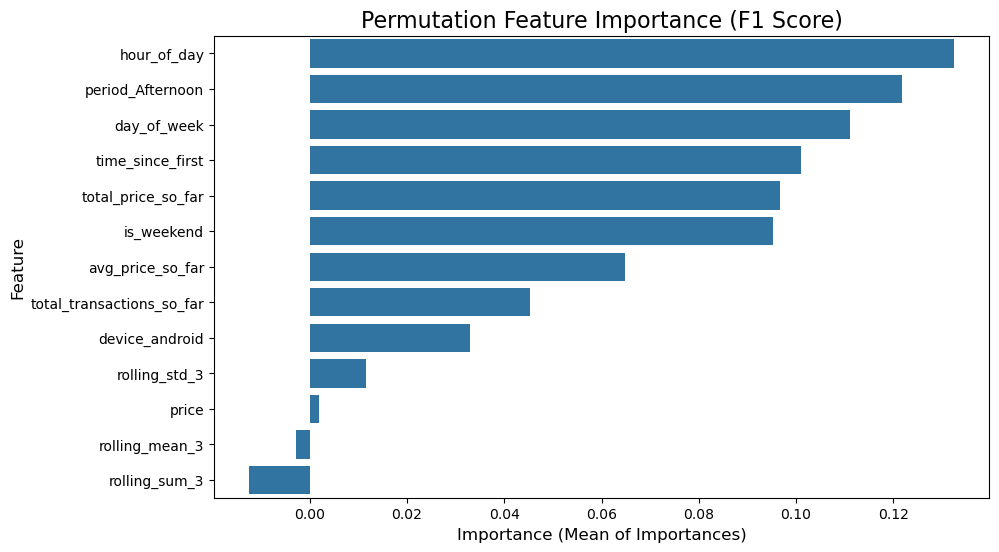


Permutation Feature Importance Table:
                      Feature  Permutation Importance
2                 hour_of_day                0.132410
9            period_Afternoon                0.121700
10                day_of_week                0.111149
7            time_since_first                0.101016
8          total_price_so_far                0.096706
11                 is_weekend                0.095152
0            avg_price_so_far                0.064750
6   total_transactions_so_far                0.045276
5              device_android                0.033045
4               rolling_std_3                0.011582
12                      price                0.002021
3              rolling_mean_3               -0.002870
1               rolling_sum_3               -0.012407

Global Explainability (SHAP Feature Importance):


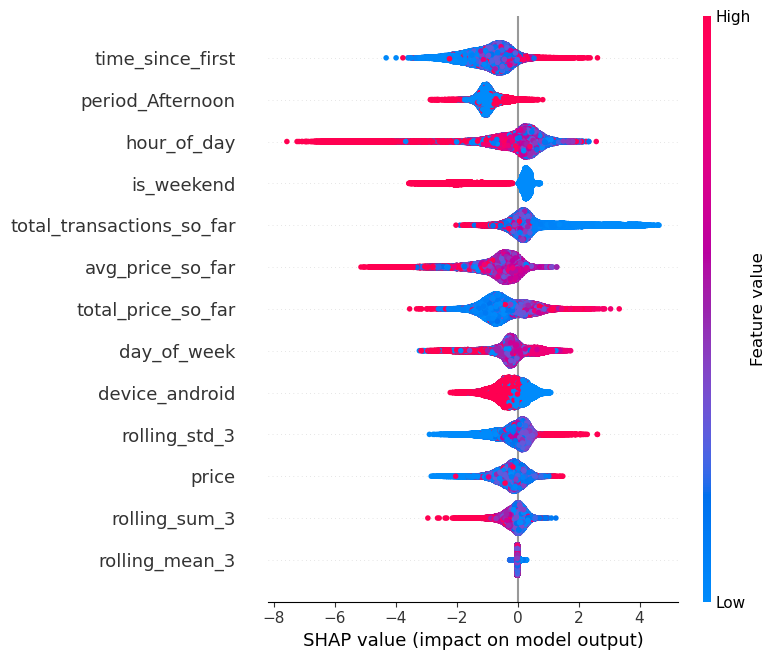


SHAP Feature Importance Table:
                      Feature  SHAP Importance
7            time_since_first         0.961295
9            period_Afternoon         0.940802
2                 hour_of_day         0.787608
11                 is_weekend         0.730724
6   total_transactions_so_far         0.722593
0            avg_price_so_far         0.697270
8          total_price_so_far         0.659751
10                day_of_week         0.495160
5              device_android         0.400468
4               rolling_std_3         0.388768
12                      price         0.354292
1               rolling_sum_3         0.240800
3              rolling_mean_3         0.023709


In [15]:
# Get global explainability (Permutation Feature Importance)
trainer.global_explainability()

### Conclusions

The combination of **permutation importance** and **SHAP values** reveals a robust
understanding of feature influence on fraud detection.

- **Time-Based Features Are Dominant:** Both SHAP and permutation importance confirm
that hour_of_day, period_Afternoon, day_of_week, and time_since_first are the strongest
fraud predictors. The timing of a transaction significantly influences fraud probability,
suggesting behavioral fraud patterns.

- **Transaction History Matters:** Total_price_so_far and total_transactions_so_far rank
high in both analyses, confirming that cumulative spending patterns impact fraud
detection.

- **SHAP Reveals Directionality:** Features like is_weekend and total_price_so_far
show mixed effects—some values increase fraud risk while others reduce it—indicating
complex relationships that a simple permutation test alone wouldn't capture.

- **Weak and Negative Contributors:** Features like rolling_mean_3 and rolling_sum_3
show minimal or even negative impact in both metrics, suggesting they may introduce
noise rather than valuable signal.

Overall, fraud likelihood is highly time-sensitive and behavior-driven, with transaction
frequency and spending habits playing a major role. The alignment of SHAP and
permutation results strengthens confidence in the model's ability to identify fraud
risks based on temporal and financial patterns.
